# VALMET DATA CHALLENGE

Import necessary libraries

In [168]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import seaborn as sns
from sklearn import preprocessing
sns.set()

Load data into dataframe

In [169]:
#load dataset into dataframe

sensor_df = pd.read_csv('Valmet_sensor_data.csv',float_precision='round_trip')

sensor_df.head()

,Time,Dry Weight,Moisture 1,Moisture 2,Coat Weight 1,Basis Weight,Coat Weight 2,Roughness,Filler Flume Consistency,Dryer Control 1,Filler Amount,Nipload,Press Control,Speed,Dryer Control 2,Water Flow
0,1.6.2020 0:00,57.982088,8.063702,NaN,5.931029,NaN,1.700335,NaN,0.105449,31.015667,0.3,178.076936,36.149757,1851.000000,32.600708,854.665300
1,1.6.2020 0:10,57.938079,7.906487,NaN,5.964949,NaN,1.700671,NaN,0.105300,30.804412,0.3,178.018339,35.888979,1851.000000,32.451856,754.036580
2,1.6.2020 0:20,57.977710,7.952795,6.24,5.943388,63.81,1.700528,4.11,0.103361,30.592229,0.3,177.897150,35.674022,1851.000000,32.179806,666.882218
3,1.6.2020 0:30,57.995342,8.052985,NaN,5.931491,NaN,1.700883,NaN,0.101526,30.447916,0.3,178.248232,35.557136,1851.000000,32.029520,629.219831
4,1.6.2020 0:40,57.997410,7.950365,NaN,5.942987,NaN,1.700414,NaN,0.100664,30.290527,0.3,178.259663,35.394812,1851.341017,31.896607,652.959524


# DATA CLEANING

The "time" column is dropped in the cleaning process because the we are solving a multilinear regression problem and not a forecasting problem <br>

Also I decided to drop the rows with NaN's because there are the intermitten values gotten before the paper is produced. So this approach <br>

focuses on the data points obtained at the end of paper production

In [170]:
# simplistic method of dropping all NaN rows i.e dropping all the intermittent data point before paper production
# this will greatly reduce the amount of the data


#take a copy of the original dataset
sensor_model_1_df = sensor_df


# data cleaning
# drop time column as it is not needed in modelling
sensor_model_1_df = sensor_model_1_df.drop(columns='Time')

cols = sensor_model_1_df.columns


#drop all rows with NaN
sensor_model_1_df = sensor_model_1_df.dropna()
sensor_model_1_df = sensor_model_1_df.reset_index(drop=True)

#normalize data to bring the predictors and resonce value to the same space
sensor_model_1_df = preprocessing.normalize(sensor_model_1_df)
sensor_model_1_df = pd.DataFrame(sensor_model_1_df, columns=cols)

model_1_X = sensor_model_1_df.drop(columns=['Roughness'])
model_1_Y = sensor_model_1_df['Roughness']



In [171]:
# split data for model 1 into train and test split (using a 70/30 split)
model_1_X_train, model_1_X_test, model_1_Y_train, model_1_Y_test = train_test_split(model_1_X, model_1_Y
                                                                                   , test_size=0.30, random_state=42) #maintaining random state to aid reproducibility



We select the most relevant features based on the pearson correlation with response data "Roughness" <br>

The plot below shows how correlated the predictors are to "Roughness"


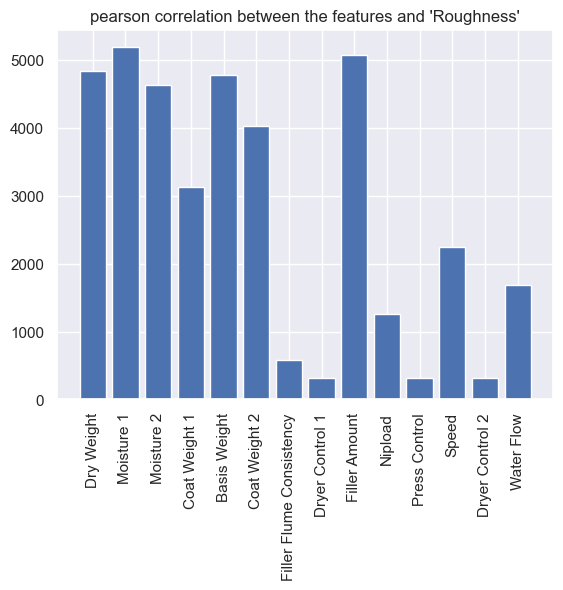

In [172]:
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(model_1_X, model_1_Y)
# transform train input data
X_train_fs = fs.transform(model_1_X)
# plot the scores
plt.bar(list(model_1_X.columns), fs.scores_)
plt.title("pearson correlation between the features and 'Roughness'")
plt.xticks(rotation=90)

plt.show()

In [173]:
#feature selection for model based on pearson correlation to select the top k parameters

def select_features(X_train, y_train, X_test,k):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs


# Model Training

Then we iterate over the various parameter from the selection, fit them to a linear regressor <br>

and a random forest regressor, then predict the test data with the regressors <br>


In [174]:
#train the regression model with varying best parameters from 1 to the total number of params
total_parameters = len(model_1_X.columns)
lr_mse = []
lr_rsquared = []
rf_mse = []
rf_rsquared = []
params = []
lr_model_coeff = []
rf_model_coeff = []



for k in range(1, total_parameters+1):
    
    X_train_fs, X_test_fs, fs = select_features(model_1_X_train, model_1_Y_train, model_1_X_test, k)
    # now we fit a multiregression line to the train data and use the model obtained to predict the test data

    #apppend names of selected features
    params.append(fs.get_feature_names_out())

    #fit linear regressor to the data 
    linreg = linear_model.LinearRegression().fit(X_train_fs,model_1_Y_train)
    lr_model_coeff.append(linreg.coef_)

    #predict the test data with the regressor
    linregpred = linreg.predict(X_test_fs)

    #calculate mse and r2 to see how well lr model minimized error
    lr_mse.append(mean_squared_error(np.array(model_1_Y_test), linregpred))
    lr_rsquared.append(r2_score(np.array(model_1_Y_test), linregpred))


    #fit random forest regressor to data
    rf_reg = RandomForestRegressor()
    rf_reg.fit(X_train_fs,model_1_Y_train)
    rf_model_coeff.append(rf_reg.feature_importances_)
    randomforest_pred= rf_reg.predict(X_test_fs)


    #calculate mse and rf for random forest regressor
    rf_mse.append(mean_squared_error(np.array(model_1_Y_test), randomforest_pred))
    rf_rsquared.append(r2_score(np.array(model_1_Y_test), randomforest_pred))


    #print(f"model training with {k} params done")



# Model Evaluation and Plot

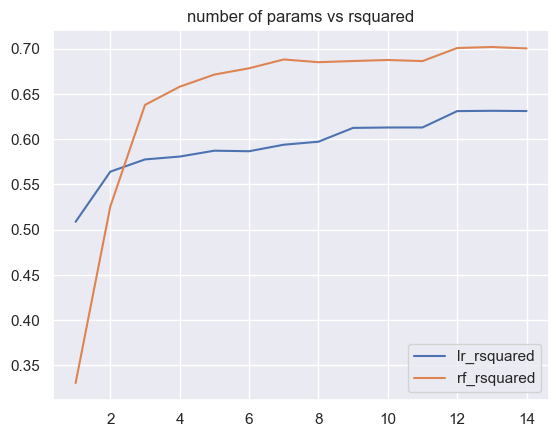

In [175]:
#plot the rsquared 
plt.plot([i for i in range(1,total_parameters+1)], lr_rsquared, label = "lr_rsquared")
plt.plot([i for i in range(1,total_parameters+1)], rf_rsquared, label = "rf_rsquared")
plt.legend()
plt.title("number of params vs rsquared")
plt.show()

In [176]:
#list of the most important features
list(params[11])

['Dry Weight',
 'Moisture 1',
 'Moisture 2',
 'Coat Weight 1',
 'Basis Weight',
 'Coat Weight 2',
 'Filler Flume Consistency',
 'Filler Amount',
 'Nipload',
 'Speed',
 'Dryer Control 2',
 'Water Flow']

The plot above shows that the randomforest regressor had a better performance on the data than the linear regressor <br>
Also we notice the highest rsquared value is obtained using 12 of the parameters listed below the plot

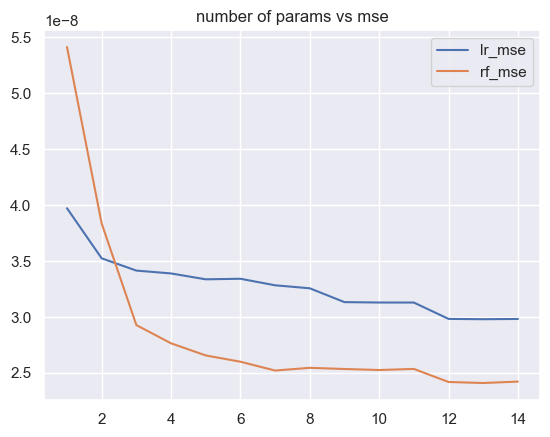

In [177]:
#plot the mse error
plt.plot([i for i in range(1,total_parameters+1)], lr_mse, label = "lr_mse")
plt.plot([i for i in range(1,total_parameters+1)], rf_mse, label = "rf_mse")
plt.legend()
plt.title("number of params vs mse")
plt.show()

In [178]:
#feature importance coeffiecient for random forest regressor
rf_model_coeff[11]

array([0.04530834, 0.12338147, 0.0462856 , 0.46093656, 0.02480185,
       0.04249636, 0.03247387, 0.10079558, 0.03507945, 0.01797265,
       0.04437546, 0.0260928 ])

In [179]:
#regression coefficients for the best model 
lr_model_coeff[11]

array([ 8.48407919e-03,  5.21936855e-02,  2.29602703e-02,  1.11806678e-02,
        2.36132248e-03,  9.87319829e-02, -3.10049354e-01,  2.96920313e+00,
        7.68147996e-05,  4.13901837e-03, -4.49191123e-03,  2.17961576e-03])

# Recommendations

From the experiment it shows that these 12 parameters ('Dry Weight', 'Moisture 1', 'Moisture 2', 'Coat Weight 1', 'Basis Weight', 'Coat Weight 2', <br>

 'Filler Flume Consistency', 'Filler Amount','Nipload', 'Speed', 'Dryer Control 2', 'Water Flow') strongly affect the roughness of the paper because <br> 
 
 both models had the best performance on them. However, the operator can only control a few of these parameters as many of them are derived <br> 
 
 calculations from the process.

### -> Improve roughness
- Increase in filler added during production will increase the paper roughness. This is due to the positive correlation and high coefficient of the "Filler Amount" parameter in the two regression 
model.

- Increasing the moisture (by careful increase in water flow) and reducing the drying control (to preserve more moisture) will also increase the paper "Roughness".


### -> Improve model
- It was observed that the normalization affected range of the "Filler Amount", so we could try a different method of normalization and observe the result.

- The data cleaning approach dropped a signaficant chunk of data because they were unknown (i.e data points before the paper is made). We could intrapolate those missing values with the mean, max, min or use some ML intrapolation techniques to fill the missing points. This will give us more data for the model however, the accuracy might be affected.
- Experiment with other methods of feature selection like "Mutual Information Gain"
- Extend the problem to a deep neural network
